<a href="https://colab.research.google.com/github/JamesMungai254/TB_CXR_ANALYSIS/blob/main/TB_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install monai  torchvision tensorflow matplotlib


  Using cached monai-1.4.0-py3-none-any.whl.metadata (11 kB)
Using cached monai-1.4.0-py3-none-any.whl (1.5 MB)


In [ ]:
!pip install torch

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3


In [ ]:
# prompt: check what is on  /root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3 path

import os
print(os.listdir('/root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3'))


['TB_Chest_Radiography_Database']


In [ ]:
# prompt: cd to TB_Chest_Radiography_Database

%cd /root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3/TB_Chest_Radiography_Database


/root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3/TB_Chest_Radiography_Database


In [ ]:
# prompt: check what inside this folde

import os
print(os.listdir())

['Normal', 'README.md.txt', 'Normal.metadata.xlsx', 'Tuberculosis.metadata.xlsx', 'Tuberculosis']


In [ ]:
# prompt: cd to the next folder

%cd /root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3/TB_Chest_Radiography_Database


/root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3/TB_Chest_Radiography_Database


In [ ]:
# prompt: current path
import os
import torch
import torch.nn as nn
import torch.optim as optim
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Resized,
    ScaleIntensityd,
    EnsureTyped,
    ToTensord,
    Lambdad,
)
from monai.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import os
print(os.getcwd())

/root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3/TB_Chest_Radiography_Database


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define data paths
data_dir = "/root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3/TB_Chest_Radiography_Database"
normal_images = [os.path.join(data_dir, "Normal", f) for f in os.listdir(os.path.join(data_dir, "Normal"))]
tb_images = [os.path.join(data_dir, "Tuberculosis", f) for f in os.listdir(os.path.join(data_dir, "Tuberculosis"))]


In [ ]:
# Create labels (0 = Normal, 1 = TB)
normal_labels = [0] * len(normal_images)
tb_labels = [1] * len(tb_images)


In [ ]:
# Combine data
all_data = [{"image": img, "label": lbl} for img, lbl in zip(normal_images + tb_images, normal_labels + tb_labels)]


In [ ]:

# Split data into train and validation
train_data, val_data = train_test_split(all_data, test_size=0.2, random_state=42)


In [ ]:
# Ensure all images have three channels
def ensure_three_channels(image):
    """Ensure the image has 3 channels (e.g., replicate grayscale)."""
    if image.shape[0] == 1:  # Grayscale
        return image.repeat(3, 1, 1)
    return image


In [ ]:

# Define MONAI transformations
transform = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Resized(keys=["image"], spatial_size=(256, 256)),
    ScaleIntensityd(keys=["image"]),
    Lambdad(keys=["image"], func=ensure_three_channels),  # Ensure 3 channels
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"]),
    Lambdad(keys=["label"], func=lambda x: torch.tensor(x, dtype=torch.long)),  # Cast labels to long
])

In [ ]:
# Create Datasets and DataLoaders
train_dataset = Dataset(data=train_data, transform=transform)
val_dataset = Dataset(data=val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
# Verify DataLoader outputs
for batch in train_loader:
    images, labels = batch["image"], batch["label"]
    print(f"Batch images shape: {images.shape}, dtype: {images.dtype}")
    print(f"Batch labels shape: {labels.shape}, dtype: {labels.dtype}")
    break


<ipython-input-42-de1b92db36b0>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambdad(keys=["label"], func=lambda x: torch.tensor(x, dtype=torch.long)),  # Cast labels to long


Batch images shape: torch.Size([16, 3, 256, 256]), dtype: torch.float32
Batch labels shape: torch.Size([16]), dtype: torch.int64


In [ ]:
# Define the model (ResNet18 as an example)
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust for 2 classes
model = model.to(device)

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")


<ipython-input-42-de1b92db36b0>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambdad(keys=["label"], func=lambda x: torch.tensor(x, dtype=torch.long)),  # Cast labels to long


Epoch 1/10, Loss: 0.08102995342314465
Epoch 2/10, Loss: 0.05486023089255295
Epoch 3/10, Loss: 0.02981917092304987
Epoch 4/10, Loss: 0.029642755590161652
Epoch 5/10, Loss: 0.031357308888220276
Epoch 6/10, Loss: 0.018571684502005935
Epoch 7/10, Loss: 0.028861611930603562
Epoch 8/10, Loss: 0.013583624230077043
Epoch 9/10, Loss: 0.005677918864685558
Epoch 10/10, Loss: 0.0419519526743118


In [ ]:
# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")


<ipython-input-42-de1b92db36b0>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambdad(keys=["label"], func=lambda x: torch.tensor(x, dtype=torch.long)),  # Cast labels to long


Validation Accuracy: 0.9369


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Validation loop
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in val_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute evaluation metrics
accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
conf_matrix = confusion_matrix(all_labels, all_predictions)
class_report = classification_report(all_labels, all_predictions, target_names=["Normal", "Tuberculosis"])

print("Validation Accuracy: {:.4f}".format(accuracy))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


<ipython-input-42-de1b92db36b0>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambdad(keys=["label"], func=lambda x: torch.tensor(x, dtype=torch.long)),  # Cast labels to long


Validation Accuracy: 0.9369

Confusion Matrix:
 [[657  46]
 [  7 130]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.93      0.96       703
Tuberculosis       0.74      0.95      0.83       137

    accuracy                           0.94       840
   macro avg       0.86      0.94      0.90       840
weighted avg       0.95      0.94      0.94       840



<ipython-input-42-de1b92db36b0>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambdad(keys=["label"], func=lambda x: torch.tensor(x, dtype=torch.long)),  # Cast labels to long


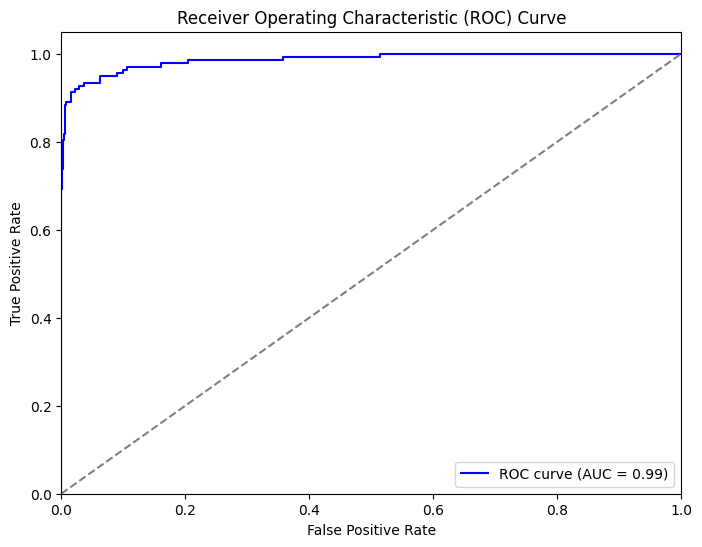

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get model predictions (probabilities for the positive class)
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        outputs = model(images)

        # Get probabilities for the positive class (class 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


<ipython-input-42-de1b92db36b0>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambdad(keys=["label"], func=lambda x: torch.tensor(x, dtype=torch.long)),  # Cast labels to long


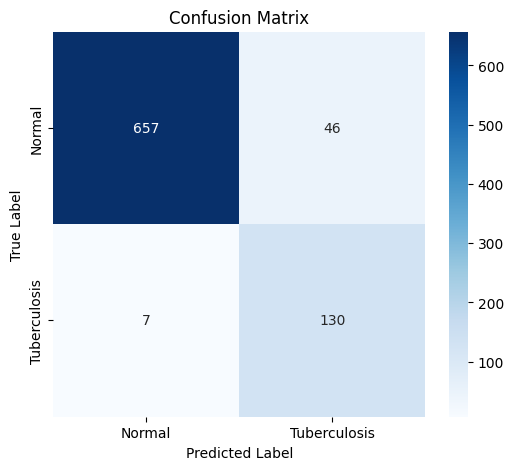

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in val_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


<ipython-input-42-de1b92db36b0>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambdad(keys=["label"], func=lambda x: torch.tensor(x, dtype=torch.long)),  # Cast labels to long


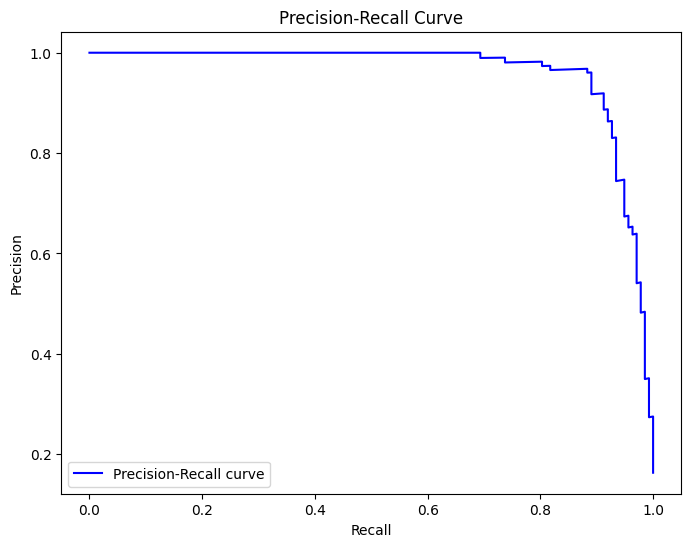

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (Tuberculosis)
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        outputs = model(images)

        # Get probabilities for the positive class (class 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
